# OOP Format Implementation of Big Moves Monday strategy
## 1. Introduction
In this notebook, we aim to provide an object-oriented format implementation of the Big Moves Monday strategy. This is useful to apply ML and pipelines for optimization and finding the optimized parameters. In addition, not only we provide an implementation of this strategy, but also this represents a clean code for it. First, let's take a look at the strategy.
### The Big Moves Monday strategy
The intuition behind this strategy is that there is an anomolly in the market, where within the full trading weeks, it is profitable to follow the last fridy trend at the beginning of this week, and close the position at the end of the week. The following indicators are one of the ways to implement this idea.

1. We calculate the $n$-day average of `relative_range = (High - Low) / Close`.
2. The Monday `Close` must be lower than the previous Friday's `Close` by at least $\alpha$ times of `relative_range`.
3. Create a variable `ibs = (Close - Low) / (High - Low)`. It must be lower than $\beta$.
4. If conditions in 2, and 3 are met, go long on Monday `Close`.
5. Square off your position on Friday `Close`.

These parameters have been studied and it is suggested to use $n=25$, $\alpha = 0.25$, and $\beta = 0.3$. Note that the second condition suggests how strong must the trend be to secure its continum. Let's check each condition separatly in more details.

1. This parameter shows a kind of fluctuations of the price per day. We want to make sure that the Friday trend followed on Monday is not just a noise. Note that deviding by `Close` is to standardize our parameter.
2. For example, if the prices on each day is steady, any diversion from the Friday's price is acceptable.
3. Not only we want the Monday's price to be lower than the previous Friday's price, but also on the same day, i.e., Monday, it seems that we are looking for a high fluctuation, mostly a buy trap (my personal thought).
> After a thorough search on this, I have found out that `ibs`, which stands for Internal Bar Strength, is an indicator, that if it is low, then it seems that the stock was oversold today, and probably we will see a price rising in the near-term, and vice versa for the case when ibs is high. The following picture, taken from [https://enlightenedstocktrading.com/mean-reversion-trading-indicators-internal-bar-strength-explanation/](Here) depicts different types of candles for different values of ibs.
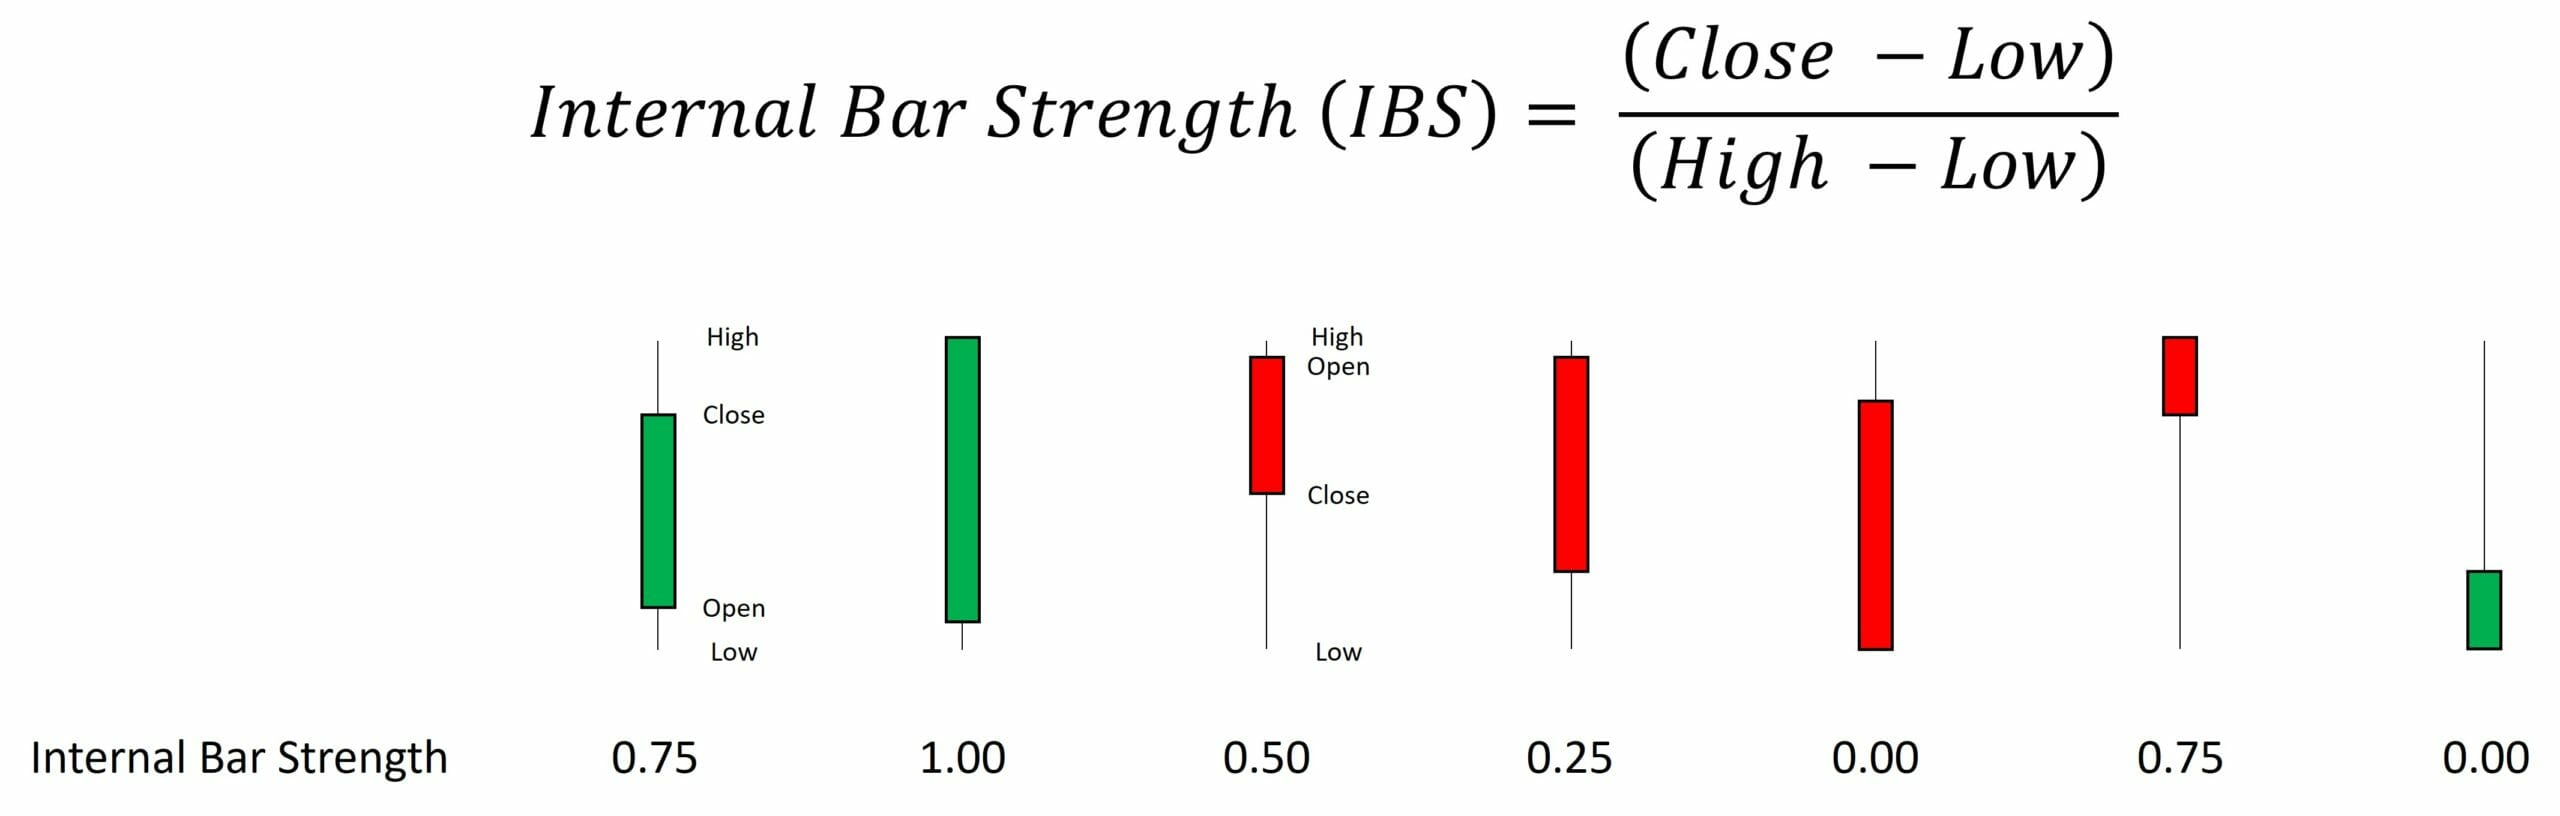


### Self motivated added features
In addition to the long conditions, I guess that a similar conditions for shoting might work as well. We will test the results for shorting seperately.
1. We calculate the $n$-day average of `relative_range = (High - Low) / Close`.
2. The Monday `Close` must be greater than the previous Friday's `Close` by at least $\alpha$ times of `relative_range`.
3. Create a variable `ibs = (Close - Low) / (High - Low)`. It must be greater than $\beta'$.
4. If conditions in 2, and 3 are met, go long on Monday `Close`.
5. Square off your position on Friday `Close`.
Since the conditions of short and long positions are non-overlapping, and the fact that the position periods are non-overlapping as well, to analyze the algorithm that allows both long and short positions, we can simply combine the profits of both restricted algorithms. 

### Trading assumptions
1. At any point, we either go long or short by at most one share.
2. We only trade on weeks that there is no holiday during the week, and the privous Friday is also a working day.
3. We open our position on Mondays, including the close price of Monday. Indeed, we assume that the last 15 min price is a close approximation of the `Close` on that day.
4. We close our position on Friday. This is a disatvantage for this strategy, as there is no flexibility of taking profit or stoping loss, which makes the trader on high risk. It also does not give an option to the trader to take in the news during the week, which might highly affect the prices.

### Acknowledgement
I learned about this strategy through the EPAT program by QuantInsti. Thank yo for support!

Moreover, The content and codes provided in this notebook are written by myself with indirect help of class excersises on this topic. Although I have got help of ChatGPT to research on the topic and terms, no content has been copied paste directly. Thank you for support!

---

## 2. Library Importing
We first import the following libraries which are used over this implementation.

In [4]:
# %pip install quantstats

In [5]:
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import quantstats as qs
import warnings

warnings.filterwarnings('ignore')

Additionally, I will use mplfinance library to depict the candles to have a visuallization of the types of candles which we enter the market

In [10]:
import mplfinance as mpf

## 3. Long-only Strategy Backtesting
Through the below code, we define a class which by creating any instance object of it, given inputs for the parameters, it runs a backtesting on it. It has a function to analyze the results afterwards.

In [94]:
class LongBMMStrategy:
    """
    Represents an instance of backtesting the Big Moves Monday Strategy, restricted to long only positions.
    
    Parameters:
        ticker (str): Stock ticker symbol
        start_date (str): Start date of the historical data
        end_date (str): End date of the historical data
        n (int): Rolling window size of relative range
        alpha (float): Threshold multiplier of fall on monday
        beta (float): Threshold for ibs condition
    """
    def __init__(self, ticker, start_date, end_date, n, alpha, beta):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.n = n
        self.alpha = alpha
        self.beta = beta
        
        # Backtesting the strategy
        self.fetch_data()
        self.prepare_data()
        self.long_indicators()
        self.long_signals()
        
    
    def fetch_data(self):
        self.df = yf.download(self.ticker, start = self.start_date, end = self.end_date, interval = '1d')
        
        
    def prepare_data(self):
        self.df['relative Adj'] = (self.df['Close'] / self.df['Adj Close'])
        self.df['Adj High'] = self.df['High'] * self.df['relative Adj']
        self.df['Adj Low'] = self.df['Low'] * self.df['relative Adj']
        
    
    def long_indicators(self):
        self.df['relative_range'] = ((self.df['Adj High'] - self.df['Adj Low']) 
                                     / self.df['Adj Close']
                                    ).rolling(window=self.n, center=False).mean()
        self.df['ibs'] = (self.df['Adj Close'] - self.df['Adj Low']) / (self.df['Adj High'] - self.df['Adj Low'])
        self.df['Day Name'] = self.df.index.day_name()
        
        self.df['condition_day'] = np.where((self.df['Day Name'] == 'Monday')
                                            & (self.df['Day Name'].shift() == 'Friday')
                                            & (self.df['Day Name'].shift(-4) == 'Friday'), True, False)
        
        self.df['condition_fall'] = np.where(self.df['Adj Close'] < self.df['Adj Close'].shift()
                                            - self.alpha * self.df['relative_range'], True, False)
        
        self.df['condition_ibs'] = np.where(self.df['ibs'] < self.beta, True, False)
        
        self.df.dropna(inplace=True)
    
    
    def long_signals(self):
        self.df['signals'] = np.where(self.df['condition_day'] 
                                     & self.df['condition_fall']
                                     & self.df['condition_ibs'], 1, 0)
        
        
    def returns(self):
        self.df['position'] = self.df['signals'].replace(to_replace=0, method='ffill', limit=4)
        self.df['bnh_returns'] = np.log(self.df['Adj Close'] / self.df['Adj Close'].shift())
        self.df['strategy_returns'] = self.df['bnh_returns'] * self.df['position'].shift()
        total_return = self.df['strategy_returns'].sum()
        print(f'The total log return of BMM strategy is {total_return*100:.2f}%, for\nn = {self.n}\nalpha = {self.alpha}\nbeta={self.beta}')
        
    
    def analysis(self):
        # plotting the returns
        self.df[['bnh_returns', 'strategy_returns']].plot(figsize=(15,6), secondary_y='position', grid=True,
                                                 title='"Buy & Hold" vs "Big Move Monday" Cummulative Returns')
        plt.show()
        
        # highlighting above the High wherever day condition is satisfied + closing the position day, i.e., shift(4)
        high_cond_day = np.where(self.df['signals'] == 1, self.df['High'] + 100, np.nan)
        cond_day_plot = mpf.make_addplot(high_cond_day, type='scatter', color='blue', markersize=5, marker='^')
        high_cond_day_shifted = np.where(self.df['signals'].shift(4) == 1, self.df['High'] + 100, np.nan)
        position_closed_plot = mpf.make_addplot(high_cond_day_shifted, type='scatter', color='purple', markersize=5, marker='^')
        
        # Final candlestick plot
        addplots = [cond_day_plot, position_closed_plot]
        mpf.plot(self.df, type='candle', style='yahoo', title=self.ticker + ' Candlestick Chart', addplot=addplots, figscale=1.5)
        
        # Generating Analyitics
        qs.reports.basic(self.df['strategy_returns'])
        

In [95]:
end_date = dt.datetime.now().date()
# Alternatively, start = dt.date.today()
start_date = end_date - pd.Timedelta(days=252)
long_bmm_standard_nsei = LongBMMStrategy(ticker='^NSEI', start_date=start_date, end_date=end_date, n=25, alpha=0.25, beta=0.3)
long_bmm_standard_nsei.returns()

[*********************100%***********************]  1 of 1 completed
The total log return of BMM strategy is 4.04%, for
n = 25
alpha = 0.25
beta=0.3


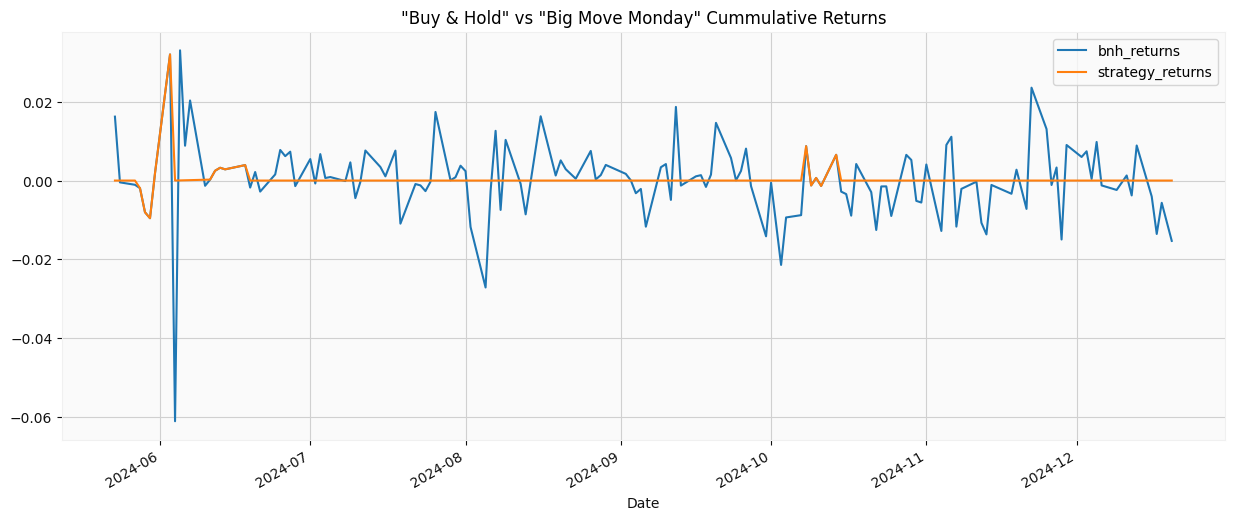

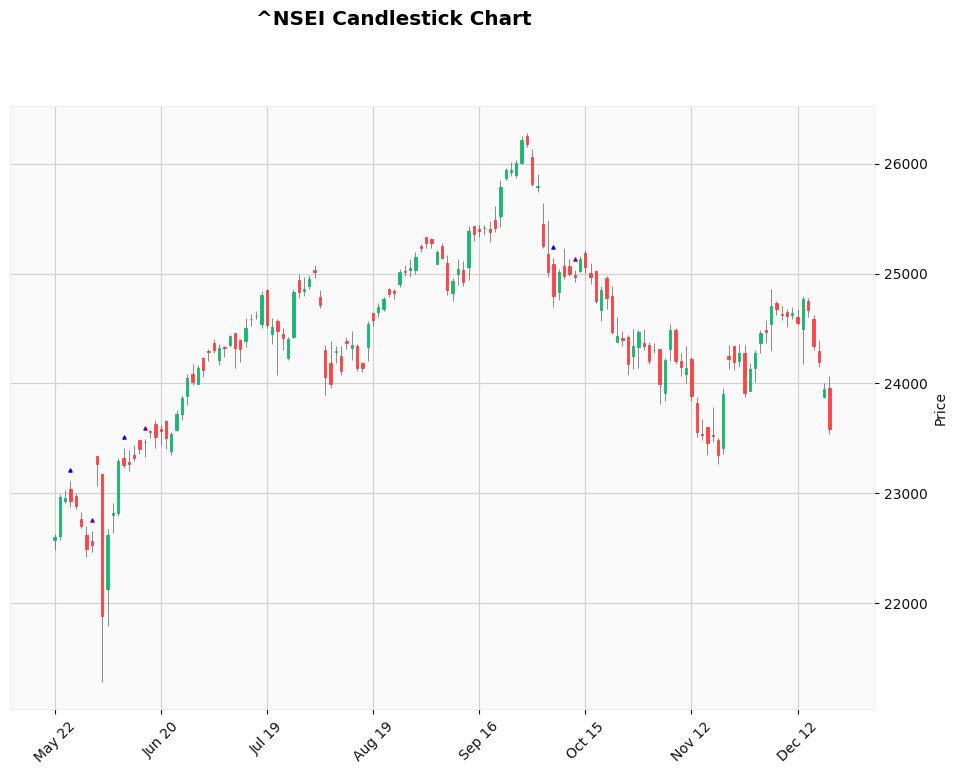

                    Strategy
------------------  ----------
Start Period        2024-05-23
End Period          2024-12-20
Risk-Free Rate      0.0%
Time in Market      11.0%

Cumulative Return   4.06%
CAGR﹪              4.86%

Sharpe              1.45
Prob. Sharpe Ratio  94.67%
Sortino             4.15
Sortino/√2          2.94
Omega               2.82

Max Drawdown        -1.94%
Longest DD Days     4

Gain/Pain Ratio     1.82
Gain/Pain (1M)      2.29

Payoff Ratio        1.41
Profit Factor       2.82
Common Sense Ratio  -
CPC Index           2.66
Tail Ratio          -
Outlier Win Ratio   17.44
Outlier Loss Ratio  1.2

MTD                 0.0%
3M                  1.33%
6M                  1.33%
YTD                 4.06%
1Y                  4.06%
3Y (ann.)           4.86%
5Y (ann.)           4.86%
10Y (ann.)          4.86%
All-time (ann.)     4.86%

Avg. Drawdown       -1.07%
Avg. Drawdown Days  4
Recovery Factor     2.08
Ulcer Index         0.0
Serenity Index      12.58


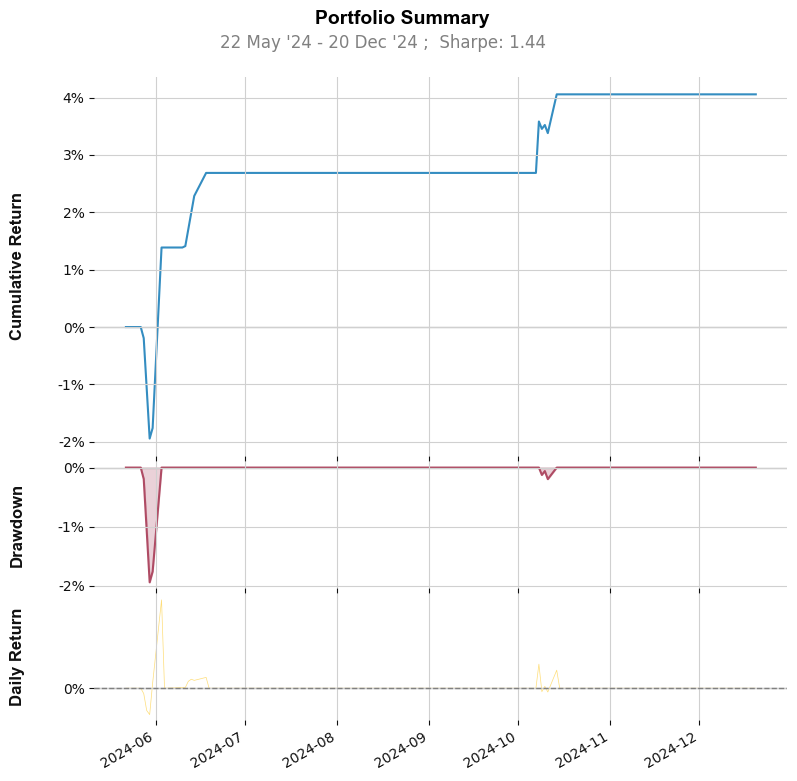

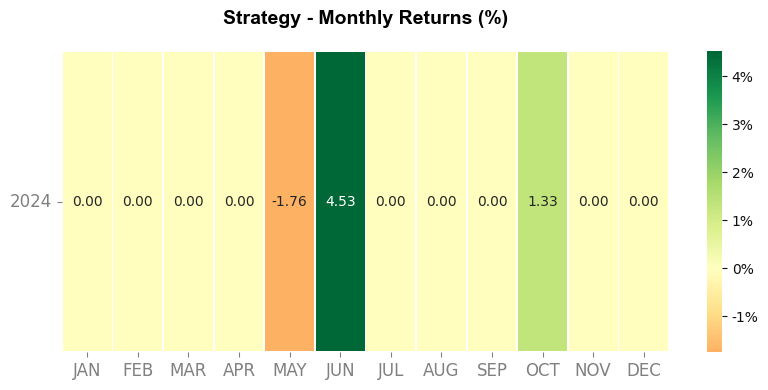

In [96]:
long_bmm_standard_nsei.analysis()

In [99]:
class BMMStrategy(LongBMMStrategy):
    def __init__(self, ticker, start_date, end_date, n, alpha, beta):
        super().__init__(ticker, start_date, end_date, n, alpha, beta)
        self.short_indicators()
        self.short_signals()
    
    def short_indicators(self):
        self.df['reversed ibs'] = (self.df['Adj High'] - self.df['Adj Close']) / (self.df['Adj High'] - self.df['Adj Low'])
        self.df['condition_rise'] = np.where(self.df['Adj Close'] > self.df['Adj Close'].shift()
                                            + self.alpha * self.df['relative_range'], True, False)
        
        self.df['condition_reversed_ibs'] = np.where(self.df['reversed ibs'] < self.beta, True, False)
        self.df.dropna(inplace=True)

    
    def short_signals(self):
        self.df['signals'] = np.where(self.df['condition_day'] 
                                     & self.df['condition_rise']
                                     & self.df['condition_reversed_ibs'], -1, self.df['signals'])

In [100]:
bmm_standard_nsei = BMMStrategy(ticker='^NSEI', start_date=start_date, end_date=end_date, n=25, alpha=0.25, beta=0.3)
bmm_standard_nsei.returns()

[*********************100%***********************]  1 of 1 completed
The total log return of BMM strategy is -1.57%, for
n = 25
alpha = 0.25
beta=0.3


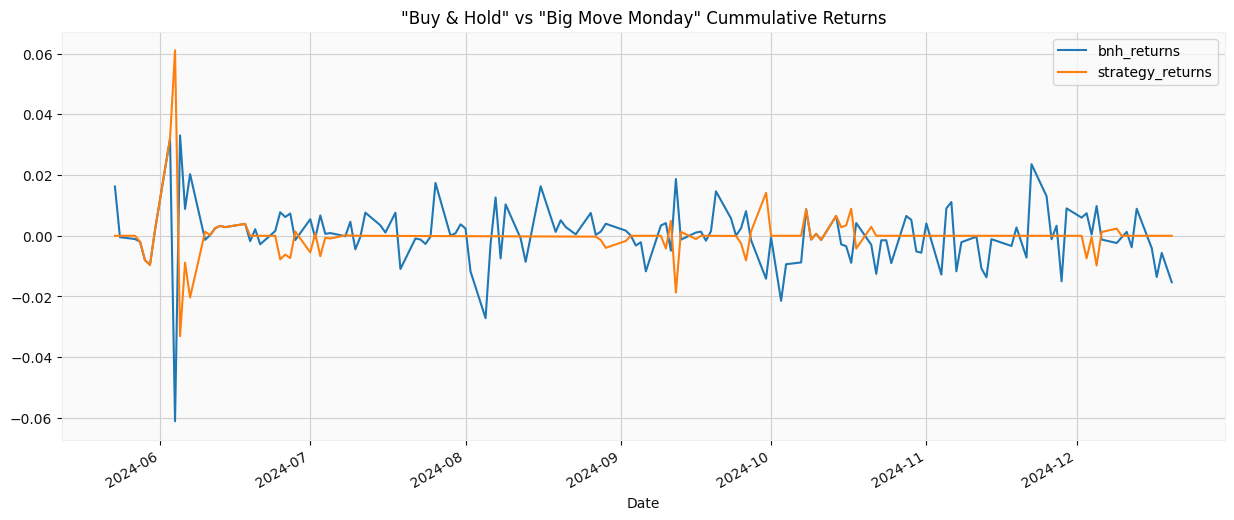

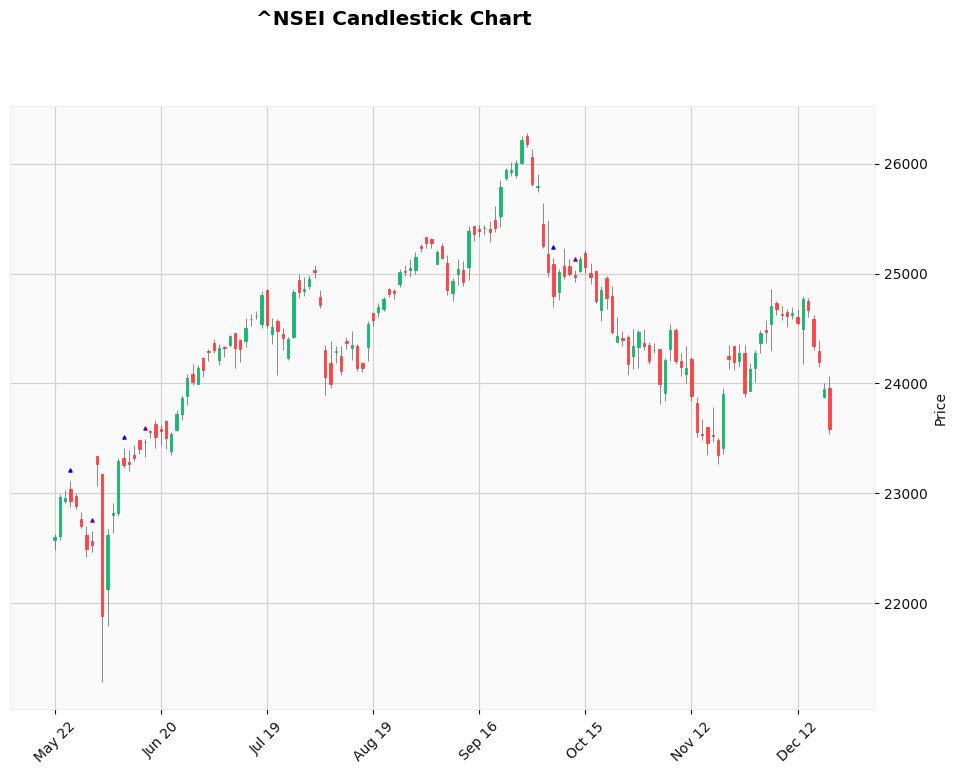

                    Strategy
------------------  ----------
Start Period        2024-05-23
End Period          2024-12-20
Risk-Free Rate      0.0%
Time in Market      38.0%

Cumulative Return   -1.94%
CAGR﹪              -2.31%

Sharpe              -0.23
Prob. Sharpe Ratio  43.21%
Sortino             -0.4
Sortino/√2          -0.29
Omega               0.92

Max Drawdown        -11.41%
Longest DD Days     199

Gain/Pain Ratio     -0.08
Gain/Pain (1M)      -0.23

Payoff Ratio        1.1
Profit Factor       0.92
Common Sense Ratio  0.44
CPC Index           0.46
Tail Ratio          0.48
Outlier Win Ratio   16.29
Outlier Loss Ratio  3.15

MTD                 -1.4%
3M                  1.8%
6M                  -4.28%
YTD                 -1.94%
1Y                  -1.94%
3Y (ann.)           -2.31%
5Y (ann.)           -2.31%
10Y (ann.)          -2.31%
All-time (ann.)     -2.31%

Avg. Drawdown       -6.68%
Avg. Drawdown Days  102
Recovery Factor     0.14
Ulcer Index         0.08
Serenity Index    

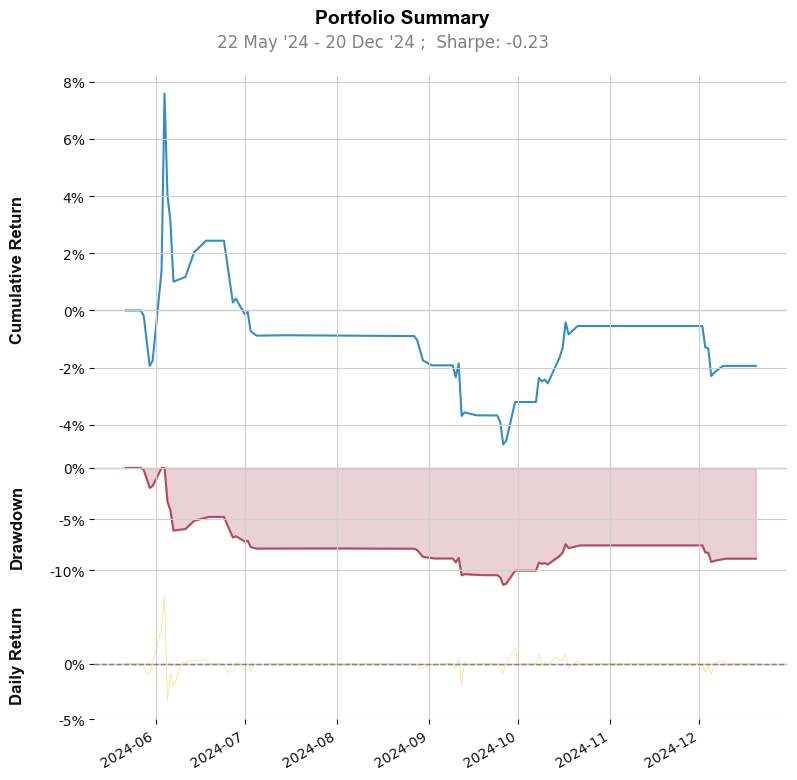

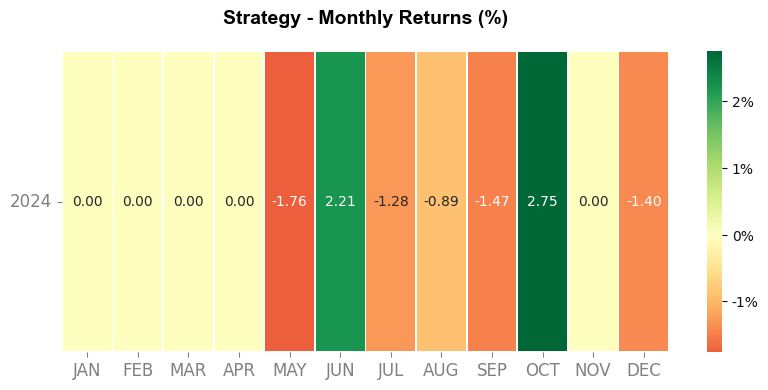

In [101]:
bmm_standard_nsei.analysis()